In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")
from matplotlib.gridspec import GridSpec
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input
results_dir = "results/kato/2018-08-30/D{}".format(D)
figures_dir = os.path.join(results_dir, "figures")

In [6]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]

K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


# Dimensionality reduction on $\Delta$F/F 

In [7]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)

lim = 1.1 * abs(np.vstack(xs)).max()

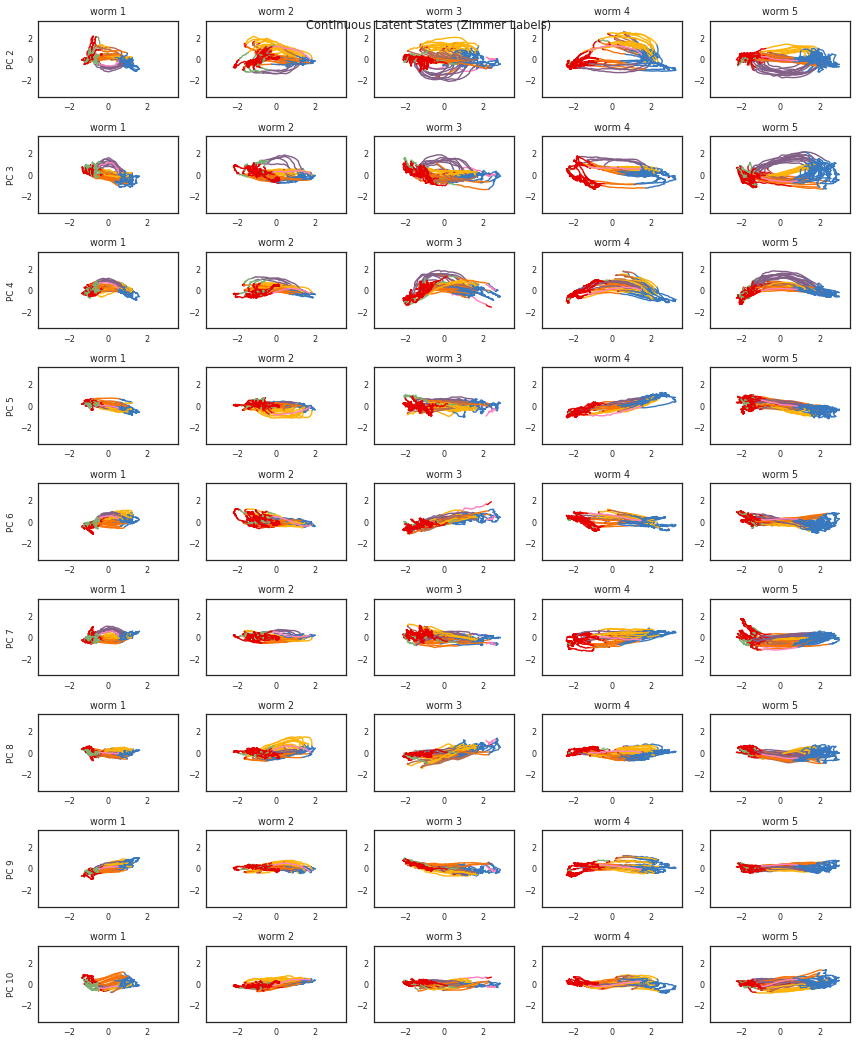

In [8]:
plt.figure(figsize=(12, 16))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    for d in range(1, D):
        ax = plt.subplot(D, W, (d-1) * W + w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
        plt.ylabel("PC {}".format(d+1) if w == 0 else "")
        plt.title("worm {}".format(w+1))

plt.suptitle("Continuous Latent States (Zimmer Labels)")
plt.tight_layout()

In [9]:
# Load the best hierarchical HMM
with open(os.path.join(results_dir, "best_hhmm_recurrent_robust_ar.pkl"), "rb") as f:
    hhmm, _ = pickle.load(f)
    
# Get the inferred states
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

In [20]:
# Load the best standard HMM
with open(os.path.join(results_dir, "best_hmm_recurrent_robust_ar.pkl"), "rb") as f:
    hmm, _ = pickle.load(f)
    
# Get the inferred states
hmm_z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(hmm_z_infs)))
hmm_z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

# Make Figure 1: Real data, continuous states, discrete states

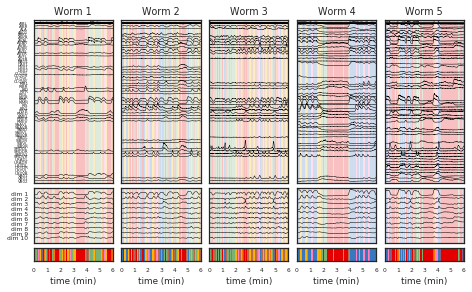

In [8]:
def make_figure_1(overlay=True, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, W, height_ratios=[12, 4, 1])

    for w in range(W):
        
        # Plot neural activity
        ax = fig.add_subplot(gs[0, w])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (ys[w][slc] - np.arange(N)) * ms[w][slc], '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names, fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        ax.set_title("Worm {}".format(w+1))

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, w])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -D, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (xs[w][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
            # ax.set_ylabel("Continuous States")
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = fig.add_subplot(gs[2, w])
        ax.imshow(z_infs[w][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

    figname = "figure1" if overlay else "figure1_white"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_1(overlay=True)
# make_figure_1(overlay=False)

# Make Figure 2

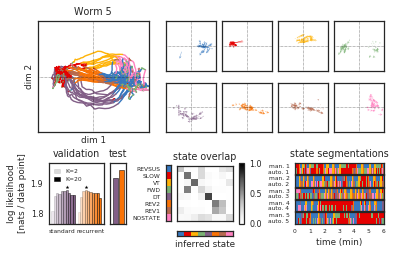

In [87]:
def make_figure_2(w=2, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.
    
    # Precompute stuff
    z = z_infs[w]
    x = xs[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
    
    # Compute normalized overlap
    K_zimmer = 8
    overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
    for ww in range(W):
        for k1 in range(K_zimmer):
            for k2 in range(hhmm.K):
                overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

    # Normalize the overlap from all worms and plot
    overlap /= overlap.sum(1)[:, None]


    # Make plot
    fig = plt.figure(figsize=(6.5, 4.5))
    fig.patch.set_alpha(0)
    
    gs = GridSpec(int(4 / .1), int(6.5 / .1))

    # a. Plot the continuous latent states
    ax = fig.add_subplot(gs[:20,:20], aspect="equal")
    ax.patch.set_alpha(0)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, 0],
                x[cp_start:cp_stop + 1, 1],
                 '-', color=zplt.default_colors[z[cp_start]])        
    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(1))
    ax.set_xticks([])
    ax.set_ylim(-3, 3)
    ax.set_ylabel("dim {}".format(2))
    ax.set_yticks([])
    ax.set_title("Worm {}".format(w+1))
    
    # b. Plot the discrete dynamics
    qargs = dict(headwidth=7,
                 headlength=7,
                 alpha=0.75)

    for k in range(8):
        D = x.shape[1]
        ini = np.where(z == k)[0]
        if ini.size > 50:
            ini_inds = np.random.choice(ini.size, replace=False, size=50)
            ini = ini[ini_inds]

        Ak = hhmm.observations.As[w, k]
        bk = hhmm.observations.bs[w, k]
        dxdt = x.dot(Ak.T) + bk - x

        row, col = k // 4, k % 4
        ax = fig.add_subplot(gs[row * 10:row * 10 + 10, 22 + col * 10 + 1: 22+ col*10 + 10], aspect="equal")
        ax.patch.set_alpha(0)
        ax.quiver(x[ini, 0], x[ini, 1], dxdt[ini, 0], dxdt[ini, 1],
                  color=zplt.default_colors[k], **qargs)

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
    
    # c1. Plot the validation likelihood
    ax = fig.add_subplot(gs[24:34, 2:12])
    Ks = np.arange(2, 21, 2)
    D_val = 24890 # Size of validation data
    with open(os.path.join(results_dir, "hhmm_results.pkl"), "rb") as f:
        hhmm_results = pickle.load(f)
        
    for i, K in enumerate(Ks):
        std_val_ll = hhmm_results["hhmm_standard_robust_ar_K{}".format(K)][2]
        ax.bar(i, std_val_ll / D_val, width=1, color=zplt.default_colors[4], edgecolor='k', linewidth=.5, alpha=.05 + .95 * (K/20))
        if K == 14:
            ax.plot(i, (std_val_ll + 200) / D_val, 'k*', markersize=4)
        
        rec_val_ll = hhmm_results["hhmm_recurrent_robust_ar_K{}".format(K)][2]
        ax.bar(11 + i, rec_val_ll / D_val, width=1, color=zplt.default_colors[5], edgecolor='k', linewidth=.5, alpha=.05 + .95 * (K/20))     
        if K == 8:
            ax.plot(11 + i, (rec_val_ll + 200) / D_val, 'k*', markersize=4)
        
    # make dummy legend
    ax.bar(0, 0, width=1, color='k', edgecolor='k', linewidth=.5, alpha=.05 + .95 * (2/20), label="K=2")     
    ax.bar(0, 0, width=1, color='k', edgecolor='k', linewidth=.5, alpha=1, label="K=20")     
        
    ax.legend(loc="upper left", ncol=1, fontsize=6, handlelength=1, columnspacing=.5, labelspacing=.5)        
    ax.set_ylim(44000 / D_val, 49000 / D_val)
    ax.set_xticks([4, 16])
    ax.set_xticklabels(["standard", "recurrent"], fontsize=6)    
    ax.set_ylabel("log likelihood\n[nats / data point]")
    ax.set_title("validation")
    

    # c2. Plot the test likelihood
    ax = fig.add_subplot(gs[24:34, 13:16])
    D_test = 24790
    with open(os.path.join(results_dir, "best_results.pkl"), "rb") as f:
        best_results = pickle.load(f)
                
    ax.bar(0, best_results["best_hhmm_standard_robust_ar"][1] / D_test, width=.8, color=zplt.default_colors[4], edgecolor='k', linewidth=.5)
    ax.bar(1, best_results["best_hhmm_recurrent_robust_ar"][1] / D_test, width=.8, color=zplt.default_colors[5], edgecolor='k', linewidth=.5)
    ax.set_ylim(44000 / D_val, 49000 / D_val)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.75, 1.75)
    ax.set_title("test")
    
    # d. Plot the state overlap    
    ax1 = fig.add_subplot(gs[24:34, 25:35])
    im = ax1.imshow(overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_title("state overlap")

    lax = fig.add_subplot(gs[24:34, 23])
    lax.imshow(np.arange(K_zimmer)[:, None], cmap=zplt.default_cmap, 
                  vmin=0, vmax=len(zplt.default_colors) - 1, aspect=1.5)
    
    lax.set_xticks([])
    lax.set_yticks(np.arange(K_zimmer))
    lax.set_yticklabels(z_true_key, fontsize=6)

    bax = fig.add_subplot(gs[35, 25:35])
    bax.imshow(np.arange(hhmm.K)[None, :], cmap=zplt.default_cmap,  aspect="auto",
               vmin=0, vmax=len(zplt.default_colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")

    axcb = fig.add_subplot(gs[24:34, 36])
    plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])
    
    # e. Plot the manual and inferred state segmentations
    for ww in range(W):
        ax = fig.add_subplot(gs[24+ww*2:24+ww*2+2, 46:62])
        ax.imshow(np.row_stack((z_trues[ww][slc], z_infs[ww][slc])), 
                  cmap=zplt.default_cmap, 
                  vmin=0, vmax=len(zplt.default_colors) - 1, 
                  extent=(tmin, tmax, 0, 2),
                  aspect="auto")
        ax.set_xticks([])
        ax.set_yticks([1.5, .5])
        ax.set_yticklabels(["man. {}".format(ww+1), "auto. {}".format(ww+1)], fontsize=6)

        if ww == W-1:
            ax.set_xticks(np.arange(tmin, tmax+1))
            ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
            ax.set_xlabel("time (min)")
            
        if ww == 0:
            ax.set_title("state segmentations")
            
    
    figname = "figure2"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_2(w=4)


# Figure 3: Hierarchical modeling

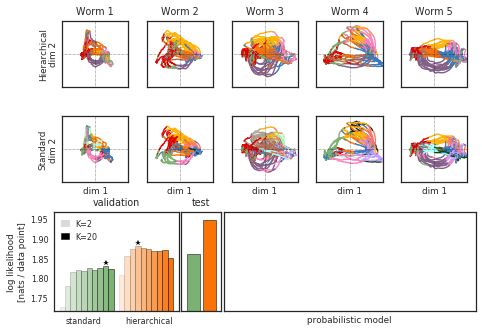

In [102]:
def make_figure_3(inds=(0, 1)):
    
    # Make plot
    fig = plt.figure(figsize=(6.5, 4.5))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, W*2, height_ratios=(1, 1, 1.5))

    for row, (name, zs) in enumerate(zip(["Hierarchical", "Standard"], [z_infs, hmm_z_infs])):
        for w in range(W):
            z = zs[w]
            x = xs[w]
            cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

            # Make plot
            ax = fig.add_subplot(gs[row, w*2:(w+1)*2], aspect="equal")
            ax.patch.set_alpha(0)

            # Color denotes our inferred latent discrete state
            for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
                ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                        x[cp_start:cp_stop + 1, inds[1]],
                         '-', color=zplt.default_colors[z[cp_start] % len(zplt.default_colors)])

            ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
            ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
            ax.set_xlim(-3, 3)
            if row == 1:
                ax.set_xlabel("dim {}".format(inds[0] + 1))
            ax.set_xticks([])
            ax.set_ylim(-3, 3)
            if w == 0:
                ax.set_ylabel(name+"\ndim {}".format(inds[1] + 1))
            ax.set_yticks([])
            
            if row == 0:
                ax.set_title("Worm {}".format(w+1))
        
    # Plot the likelihoods
    ax = fig.add_subplot(gs[2, :3])
    Ks = np.arange(2, 21, 2)
    D_val = 24890 # Size of validation data
    with open(os.path.join(results_dir, "hmm_results.pkl"), "rb") as f:
        hmm_results = pickle.load(f)

    with open(os.path.join(results_dir, "hhmm_results.pkl"), "rb") as f:
        hhmm_results = pickle.load(f)

    for i, K in enumerate(Ks):
        hmm_val_ll = hmm_results["hmm_recurrent_robust_ar_K{}".format(K)][2]
        ax.bar(i, hmm_val_ll / D_val, width=1, color=zplt.default_colors[3], edgecolor='k', linewidth=.5, alpha=.05 + .95 * (K/20))
        if K == 18:
            ax.plot(i, (hmm_val_ll + 200) / D_val, 'k*', markersize=6)
        
        hhmm_val_ll = hhmm_results["hhmm_recurrent_robust_ar_K{}".format(K)][2]
        ax.bar(11 + i, hhmm_val_ll / D_val, width=1, color=zplt.default_colors[5], edgecolor='k', linewidth=.5, alpha=.05 + .95 * (K/20))     
        if K == 8:
            ax.plot(11 + i, (hhmm_val_ll + 200) / D_val, 'k*', markersize=6)
        
    # make dummy legend
    ax.bar(0, 0, width=1, color='k', edgecolor='k', linewidth=.5, alpha=.05 + .95 * (2/20), label="K=2")     
    ax.bar(0, 0, width=1, color='k', edgecolor='k', linewidth=.5, alpha=1, label="K=20")     
        
    ax.legend(loc="upper left", ncol=1, handlelength=1, columnspacing=.5, labelspacing=.5)        
    ax.set_ylim(42700 / D_val, 49000 / D_val)
    ax.set_xticks([4, 16])
    ax.set_xticklabels(["standard", "hierarchical"])    
    ax.set_ylabel("log likelihood\n[nats / data point]")
    ax.set_title("validation")
    
    # c2. Plot the test likelihood
    ax = fig.add_subplot(gs[2, 3])
    D_test = 24790
    with open(os.path.join(results_dir, "best_results.pkl"), "rb") as f:
        best_results = pickle.load(f)
                
    ax.bar(0, best_results["best_hmm_recurrent_robust_ar"][1] / D_test, width=.8, color=zplt.default_colors[3], edgecolor='k', linewidth=.5)
    ax.bar(1, best_results["best_hhmm_recurrent_robust_ar"][1] / D_test, width=.8, color=zplt.default_colors[5], edgecolor='k', linewidth=.5)
    ax.set_ylim(42700 / D_val, 49000 / D_val)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.75, 1.75)
    ax.set_title("test")

    # Plot the graphical mode.
    ax = fig.add_subplot(gs[2, 4:])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("probabilistic model")
    
    plt.tight_layout(pad=0.25)
    
    figname = "figure3"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_3()

# Figure 4: Inputs 

In [ ]:
# Load results from Nichols et al, 2017 data

# Figure 5: Simulations

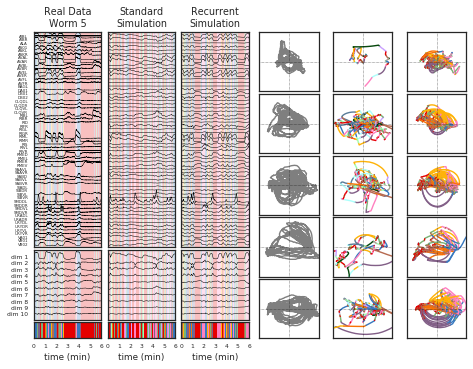

In [203]:
def make_figure_5(w, s=0, tmin=0, tmax=6):

    # Make plot
    fig = plt.figure(figsize=(6.5, 5))
    fig.patch.set_alpha(0)
    gs = GridSpec(85, 6)

    # Load simulations
    with open(os.path.join(results_dir, "best_hhmm_standard_robust_ar_sim.pkl"), "rb") as f:
        std_sims = pickle.load(f)

    with open(os.path.join(results_dir, "best_hhmm_recurrent_robust_ar_sim.pkl"), "rb") as f:
        rec_sims = pickle.load(f)
    
    datas = [(z_infs[w], xs[w], ys[w], ms[w], "Real Data\nWorm {}".format(w+1)),
             std_sims[w][s] + (np.ones_like(std_sims[w][s][2]), "Standard\nSimulation"),
             rec_sims[w][s] + (np.ones_like(rec_sims[w][s][2]), "Recurrent\nSimulation"),
            ]
    for i, (z, x, y, m, title) in enumerate(datas):
        T = y.shape[0]
        Tmax = tmax * 60 * 30 + 1
        if T < Tmax:
            y = np.row_stack((y, np.nan * np.ones((Tmax-T, y.shape[1]))))
            x = np.row_stack((x, np.nan * np.ones((Tmax-T, x.shape[1]))))
            z = np.concatenate((z, np.nan * np.ones((Tmax-T,))))
            m = np.row_stack((m, np.ones((Tmax-T, m.shape[1]))))
        
        slc = slice(tmin*60*3, tmax*60*3+1)
        tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

        
        # Plot neural activity
        ax = fig.add_subplot(gs[:60, i])
        
        ax.imshow(z[slc][None, :], 
                  vmin=0, vmax=len(zplt.default_colors)-1, 
                  cmap=zplt.default_cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -N, 1), 
                  alpha=.25)
            
        ax.plot(tslc, (y[slc] - np.arange(N)) * m[slc], '-k', lw=0.5)
        if i == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names, fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
            
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        ax.set_title(title)

        # Plot continuous latent states
        ax = fig.add_subplot(gs[60:80, i])
        ax.imshow(z[slc][None, :], 
                  vmin=0, vmax=len(zplt.default_colors)-1, 
                  cmap=zplt.default_cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -D, 1), 
                  alpha=.25)
        ax.plot(tslc, (x[slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if i == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = fig.add_subplot(gs[80:85, i])
        ax.imshow(z[slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")
        

    # Plot the simulated trajectories
    inds = (0, 1)
    for ww in range(W):
        # Make real data plot
        ax = fig.add_subplot(gs[ww*17:(ww+1)*17, 3], aspect="equal")
        ax.patch.set_alpha(0)
        ax.plot(xs[ww][:,inds[0]], xs[ww][:, inds[1]], color='k', alpha=0.5)
        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
        ax.set_xlim(-3, 3)
        ax.set_xticks([])
        ax.set_ylim(-3, 3)
        ax.set_yticks([])

        # Make the standard simulation data plot
        ax = fig.add_subplot(gs[ww*17:(ww+1)*17, 4], aspect="equal")
        ax.patch.set_alpha(0)
        
        z, x = std_sims[ww][s][:2]
        cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
        for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
            ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                    x[cp_start:cp_stop + 1, inds[1]],
                     '-', color=zplt.default_colors[z[cp_start] % len(zplt.default_colors)])

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
        ax.set_xlim(-3, 3)
        ax.set_xticks([])
        ax.set_ylim(-3, 3)
        ax.set_yticks([])
        
        # Make the recurrent simulation data plot
        ax = fig.add_subplot(gs[ww*17:(ww+1)*17, 5], aspect="equal")
        ax.patch.set_alpha(0)
        
        z, x = rec_sims[ww][s][:2]
        cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
        for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
            ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                    x[cp_start:cp_stop + 1, inds[1]],
                     '-', color=zplt.default_colors[z[cp_start] % len(zplt.default_colors)])

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)        
        ax.set_xlim(-3, 3)
        ax.set_xticks([])
        ax.set_ylim(-3, 3)
        ax.set_yticks([])
    
    plt.tight_layout(pad=0.25)

    figname = "figure5"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_5(4, s=8)